### **Deep Learning Group Project 23-24**

##### **Group 5**

**Elements**:
- ...
- ...
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- ...
- ...


**In this notebook:**
1. ... *describe main objectives of the notebook*
2. ...
3. ...


**Index**
1. Data Imports <>
2. ... <>

In [1]:
%load_ext autoreload
%autoreload 2

# *********************************
# Library Imports
# *********************************

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # trying to mute tf's warnings (not working)
import pickle
import shutil
import itertools
from typing import Union, Generator

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard, # type: ignore
                                        ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.metrics import (F1Score, Precision, Recall, CategoricalAccuracy,  # type: ignore
                                      TruePositives, TrueNegatives, FalsePositives, FalseNegatives) 
from tensorflow.keras import regularizers  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from utils.constants import CLASS_INT_TO_STR, MALIGN_DISEASES
from utils.visuals import ModelVisualEvaluation, SampleVisuals
from utils.gradcam import GradCAM, read_image_to_array

SEED = 42

In [2]:
# *********************************
# Importing data
# *********************************

# making this a function instead of importing
# straight away to add flexibility in the future
# we might want to train models with different
# batch sizes or image sizes

TRAIN_PATH = os.path.join('data', 'train')
VAL_PATH = os.path.join('data', 'val')
TEST_PATH = os.path.join('data', 'test')

def import_data(*
                batch_size: int,
                image_size: tuple,
                train_path: str = TRAIN_PATH,
                val_path: str = VAL_PATH,
                test_path: str = TEST_PATH,
                **other_import_kwargs: None) -> tuple:
        
  
    import_kwargs = {
        'labels': 'inferred',
        'label_mode': 'categorical',
        'color_mode': 'rgb',
        'batch_size': batch_size,
        'image_size': image_size,
        'seed': SEED,
        'interpolation': 'bilinear',
        'crop_to_aspect_ratio': True
    }
    
    # in case we want to add more kwargs or update existing ones
    if other_import_kwargs:
        for arg, value in other_import_kwargs.items():
            import_kwargs[arg] = value

    train_data = image_dataset_from_directory(
        train_path,
        shuffle=True,
        **import_kwargs
    )

    val_data = image_dataset_from_directory(
        val_path,
        shuffle=False,
        **import_kwargs
    )

    test_data = image_dataset_from_directory(
        test_path,
        shuffle=False,
        **import_kwargs
    )

    return train_data, val_data, test_data

# NOTE reading data to memory does not work, I get an error: MemoryError:
# Unable to allocate 2.12 GiB for an array with shape (11556, 128, 128, 3) and data type float32

In [55]:
# *********************************
# Data for debugging
# *********************************

# so far the models we have implemented
# are returning poor results. The idea here
# is to create a very small dataset (1 image
# per class) and check whether our models
# are able to overfit it otherwise there might
# be a bug in the code

# for original_path, partition in zip((TRAIN_PATH, VAL_PATH), ('train', 'val')):
#     path = os.path.join('data', f'debug_{partition}')
#     os.makedirs(path, exist_ok=True)
    
#     for class_name in os.listdir(TRAIN_PATH):
#         class_path = os.path.join(path, class_name)
#         os.makedirs(class_path, exist_ok=True)
#         # copying the first image of each class
#         img_path = os.path.join(original_path, class_name, os.listdir(os.path.join(original_path, class_name))[0])
#         shutil.copy(img_path, class_path)

# creating the datasets
# debug_train_path = os.path.join('data', 'debug_train')
# debug_val_path = os.path.join('data', 'debug_val')

# debug_train_data = image_dataset_from_directory(
#     os.path.join('data', 'debug_train'),
#     shuffle=True,
#     **import_kwargs
# )

# debug_val_data = image_dataset_from_directory(
#     os.path.join('data', 'debug_val'),
#     shuffle=False,
#     **import_kwargs
# )

In [ ]:
# # ******************************************
# # Concatenating image with numeric data
# # ******************************************

# # the idea here is to extend the image datasets
# # with numeric data (e.g. fitzpatrick scale)

# CSV_PATH = os.path.join('data', 'fitzpatrick17k.csv')

# def get_numeric_data(data: tf.data.Dataset) -> pd.DataFrame:
#     """
#     From the imported image datasets we can access
#     the path of the files. The way we stored the images,
#     i.e. the img name is the hash of the row where that
#     img exists in the original file, allows us to map each
#     image to the corresponding numeric data.
#     """
#     # extracting filenames
#     filenames = []
#     for path in data.file_paths:
#         filenames.append(os.path.basename(path))
    
#     # removing .jpg string
#     filenames = list(map(lambda x: x[:-4], filenames))
    
#     # accessing the original csv file with the num. data
#     num_data = []
#     og_df = pd.read_csv(CSV_PATH)
#     for img in filenames:
#         row_values = og_df.loc[og_df['md5hash'] == img, ['fitzpatrick_scale', 'fitzpatrick_centaur']].values.tolist()[0]
#         num_data.append(row_values)
    
#     # num_data is a list of lists and for easier
#     # manipulation we should change it to a pd df
#     num_data = pd.DataFrame(num_data, columns=['fitz_1', 'fitz_2'])
    
#     # there are pseudo-missing values (i.e. -1) that
#     # we'll replace with the average
#     num_data = num_data.replace(-1, np.nan)
#     means = np.nanmean(num_data, axis=0)
#     num_data['fitz_1'] = num_data['fitz_1'].fillna(means[0])
#     num_data['fitz_2'] = num_data['fitz_2'].fillna(means[1])
    
#     return num_data

# train_data_num = get_numeric_data(train_data)
# val_data_num = get_numeric_data(val_data)
# test_data_num = get_numeric_data(test_data)   

# # OPTIONAL   
# # NNs in general prefer its data to take on values
# # on smaller intervals, e.g. [0, 1]
# scaler = MinMaxScaler()
# train_data_num = pd.DataFrame(scaler.fit_transform(train_data_num), columns=['fitz_1', 'fitz_2'])  # fitting to train
# val_data_num = pd.DataFrame(scaler.transform(val_data_num), columns=['fitz_1', 'fitz_2']) # transforming the others
# test_data_num = pd.DataFrame(scaler.transform(test_data_num), columns=['fitz_1', 'fitz_2'])

# def concatenate_img_and_num_data(img_data: tf.data.Dataset,
#                                  num_data: pd.DataFrame) -> tf.data.Dataset:
    
#     def combine_batch(batch1, batch2):
#         (img_batch, num_batch) = batch1, batch2
#         return (
#             (img_batch[0], num_batch),
#             img_batch[1]
#         )
    
#     # turning numeric data into a tf.dataset
#     num_data = tf.data.Dataset.from_tensor_slices(num_data).batch(BATCH_SIZE)
    
#     # zipping the datasets
#     combined_data = tf.data.Dataset.zip((img_data, num_data))
    
#     # restructuring the dataset into ((image_data, num_data), labels)
#     combined_data = combined_data.map(combine_batch)
    
#     return combined_data

# train_data = concatenate_img_and_num_data(train_data, train_data_num)
# val_data = concatenate_img_and_num_data(val_data, val_data_num)
# test_data = concatenate_img_and_num_data(test_data, test_data_num)

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.


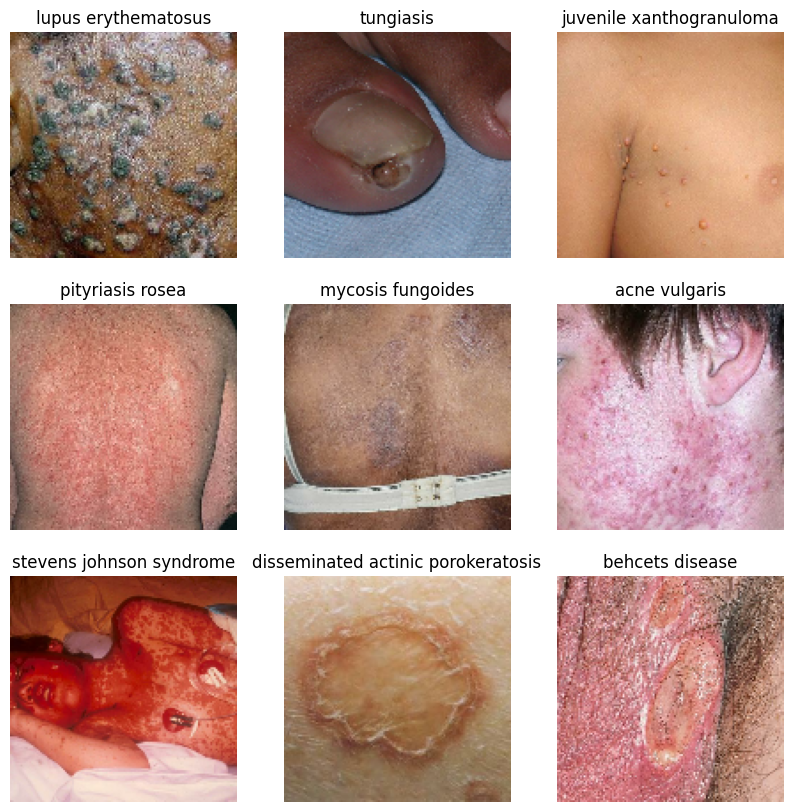

In [4]:
train_data, val_data, test_data = import_data(batch_size=32, image_size=(128, 128))

SampleVisuals.show_random_sample(train_data, 32)

In [3]:
# *********************************
# Defining class weigths
# *********************************

# our dataset shows heavy data imbalance, a first-line measure to combat
# its consequences is to set class weights, i.e. for underrepresented
# classes our model's loss will increase by a factor larger than 1 if
# the expected class is different from the real class, and will increase
# by a factor smaller than 1 for over represented classes

def get_balanced_class_weights(dir_path: str) -> dict:
        
    # also TODO check if we can increase class weights
    # for cancerous diseases
    
    y = []
    for i, dir in enumerate(os.listdir(dir_path)):
        y += [i] * len(os.listdir(os.path.join(dir_path, dir)))
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y) 

    return dict(enumerate(class_weights))
        

# run once don't need to run it again
# regardless of image size or batch size
# or any other the train dataset will
# remain the same
CLASS_WEIGHTS = get_balanced_class_weights(TRAIN_PATH)

In [4]:
# *********************************
# Mean and std
# *********************************

# common preprocessing step is to standardize
# the images, i.e. make them have a mean of 0
# and a standard deviation of 1 (per channel)

def get_mean_and_std(data: tf.data.Dataset, normalize: bool = True) -> tuple:
    """
    Returns the mean and standard deviation of the
    images in the dataset.
    
    Args:
        data: tf.data.Dataset object.
        normalize: whether to normalize the images (i.e. divide by 255).
    
    Returns:
        tuple: mean and standard deviation.
    """
    mean = []
    std = []
    for batch_x, _ in data:
        if normalize:
            batch_x = batch_x / 255.0
        mean.append(np.mean(batch_x.numpy(), axis=(0, 1, 2)))
        std.append(np.std(batch_x.numpy(), axis=(0, 1, 2)))
    
    return np.mean(mean, axis=0), np.mean(std, axis=0)

In [5]:
# *********************************
# Defining Callbacks
# *********************************

# how to implement custom metric for early stopping callback:
# similar implementation of callback that we want: https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras
# data generator and validation data error: https://stackoverflow.com/questions/61939790/keras-custom-metrics-self-validation-data-is-none-when-using-data-generators
# how to write custom callbacks: https://keras.io/guides/writing_your_own_callbacks/

# NOTES:
# - EarlyStopping: stops early if target metric not increasing
# - ModelCheckpoint: saves model
# - TensorBoard: to visually assess our model's traning
# - ReduceLROnPlateau: reduces LR dynamically

# custom LR scheduler
def lr_schedule(epoch, lr):
    # reducif LR by a factor of 10 every 7 epochs
    if epoch % 7 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

def get_callback_list(model_path: str,
                      *other_callbacks,
                      monitor:str = 'val_loss',
                      early_stop_patience: int = 1) -> list:
    """
    Returns a pre-specified, fixed, callback list
    plus any other custom callbacks added as non-keyword
    arguments.
    
    Args:
        model_path: ModelCheckpoint callback stores model
        to path.
        monitor: Metric to monitor. By default it's 'val_loss'.
        other_callbacks: Other callbacks to include.
    
    Returns:
        List of callbacks.
    """
    
    if other_callbacks:
        other_callbacks = list(other_callbacks)
    else:
        other_callbacks = []
        
    callbacks_list = [
        
        EarlyStopping(monitor=monitor,
                      patience=early_stop_patience),
        
        ModelCheckpoint(filepath=model_path,
                        monitor=monitor,
                        save_best_only=True),
        
        TensorBoard(log_dir='log_dir',
                    histogram_freq=1),
        
        ReduceLROnPlateau(monitor=monitor,
                          factor=0.1,
                          patience=5,
                          min_lr=1e-30,
                          cooldown=3,
                          verbose=0)
        
    ]

    # NOTE the order matters, the custom callback should be the first
    # in the list otherwise its logs will not be updated between epochs
    # and the other callbacks will not have be able to monitor the custom
    # metric
    return other_callbacks + callbacks_list

In [6]:
# ***************************************
# Saving and loading model histories
# ***************************************

# in case we want to save history to plot loss or
# another metric later on. we can store it as a
# pickle file sending to file

def save_model_history(history, model_name):
    with open(os.path.join('model_dir', 'history', model_name), 'wb') as history_pickle:
        pickle.dump(history, history_pickle)

def load_model_history(model_name):
    with open(os.path.join('model_dir', 'history', model_name), 'rb') as history_pickle:
        history = pickle.load(history_pickle)
    return history

In [7]:
# *********************************
# Model builder function
# *********************************

def model_builder(head_model: tf.keras.models.Sequential,
                  input_shape: tuple,
                  *,
                  preprocessing_pipeline: tf.keras.models.Sequential = None,
                  base_model: tf.keras.models.Sequential = None,
                  training: bool = False,
                  multiple_inputs: list[tf.keras.layers.Input] = None,
                  model_name: str = None) -> tf.keras.Model:
    """
    Builds a model using the provided head_model, augmentation_pipeline,
    base_model, and multiple_inputs.
    
    Args:
        head_model: model that takes the output of the base_model
        base_model: model that takes the augmented image
        training: boolean that determines whether the base_model
        will be used for training or inference.
        multiple_inputs: list of input layers that will be concatenated
        before being passed to the base_model. If None, only one input
        layer is used (pre-defined).
    
    Returns:
        tf.keras.Model: the final model
    """
    
    # input layer
    if multiple_inputs is None:
        inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    else:
        inputs = tf.keras.layers.Concatenate(axis=1)(multiple_inputs)
    
    # preprocessing
    if preprocessing_pipeline is not None:
        x = preprocessing_pipeline(inputs)
    else:
        x = inputs

    # base model
    if base_model is not None:
        try:
            x = base_model(x, training=training)
        except Exception as e:
            x = base_model(x)
            print(f'Error: {e}:')
            print('The base_model is not being used.')
    
    # adding the head
    outputs = head_model(x)
    
    # Creating the final model
    model = tf.keras.models.Model(inputs=inputs,
                                  outputs=outputs,
                                  name=model_name)
    
    return model

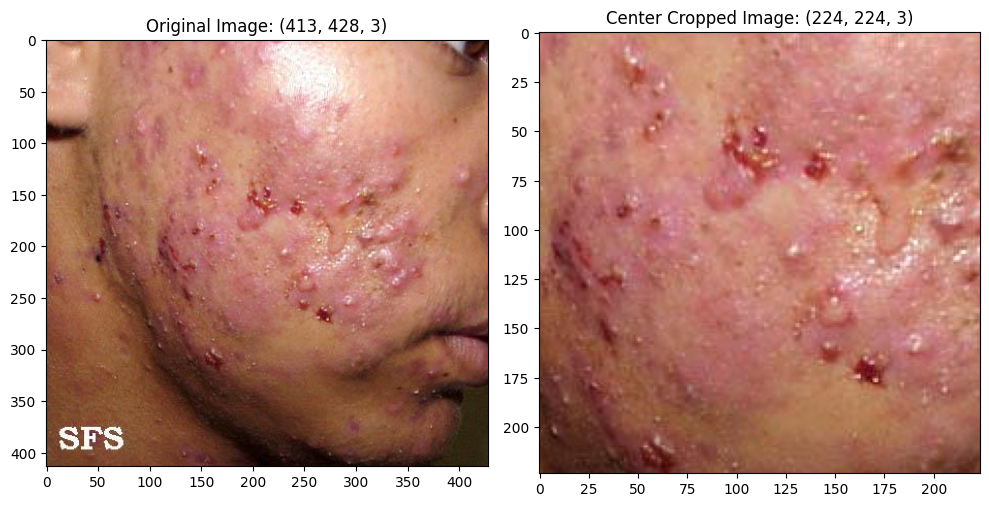

In [12]:
# ***********************************
# Image preprocessing - Center Crop
# ***********************************

# TODO
# black hat
# grabcut
# center crop images
# standardize images
# contrast

# TODO: ideas of image preprocessing:
# https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c
preprocessing_pipeline = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.CenterCrop(224, 224)
], name='preprocessing_pipeline')

# example
img_path = os.path.join('data', 'train', 'acne', '3c83e78f36f0dd1cbbd4e6e23a73d5c1.jpg')
img = cv2.imread(img_path)
img_array = np.array(img)[..., ::-1]  # BGR --> RGB

# convert to array and make batch of 1
img_array = np.expand_dims(img_array, axis=0)

# reconvert pre processed image
pp_img = preprocessing_pipeline(img_array).numpy().squeeze()

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_array.squeeze())
# ax1.axis('off')
ax1.set_title(f'Original Image: {img_array.squeeze().shape}')

ax2.imshow(pp_img)
# ax2.axis('off')
ax2.set_title(f'Center Cropped Image: {pp_img.shape}')

plt.tight_layout()
plt.show()

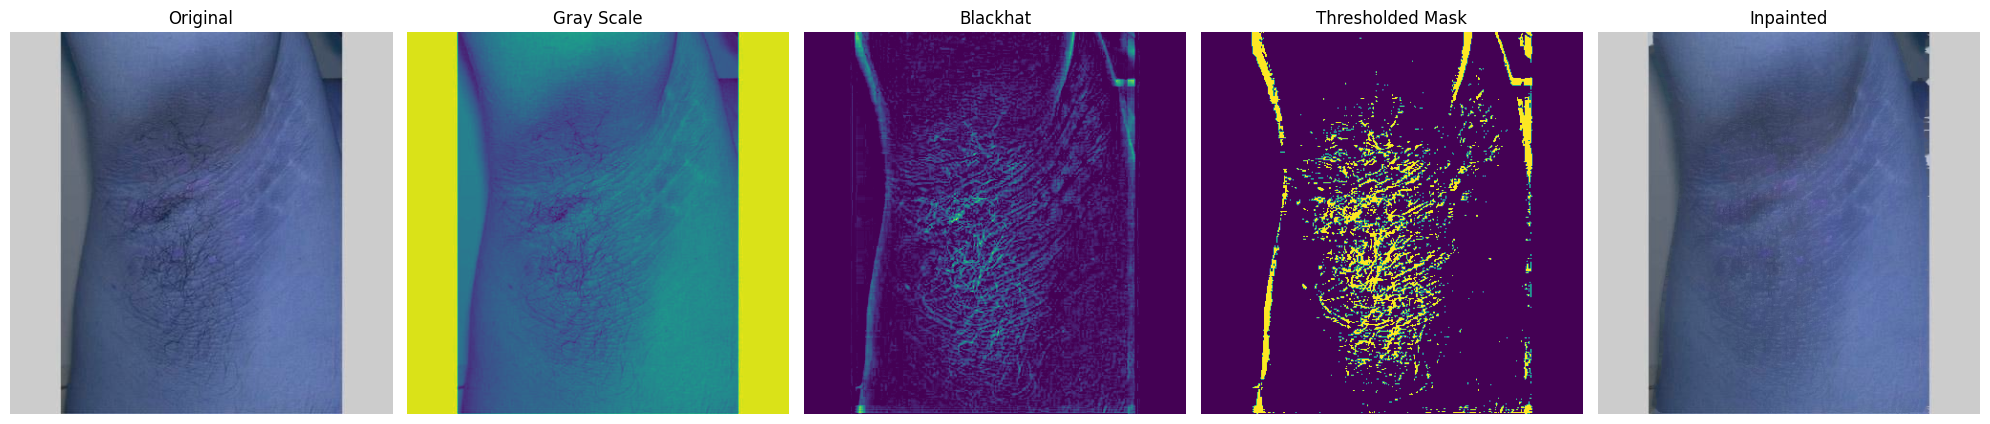

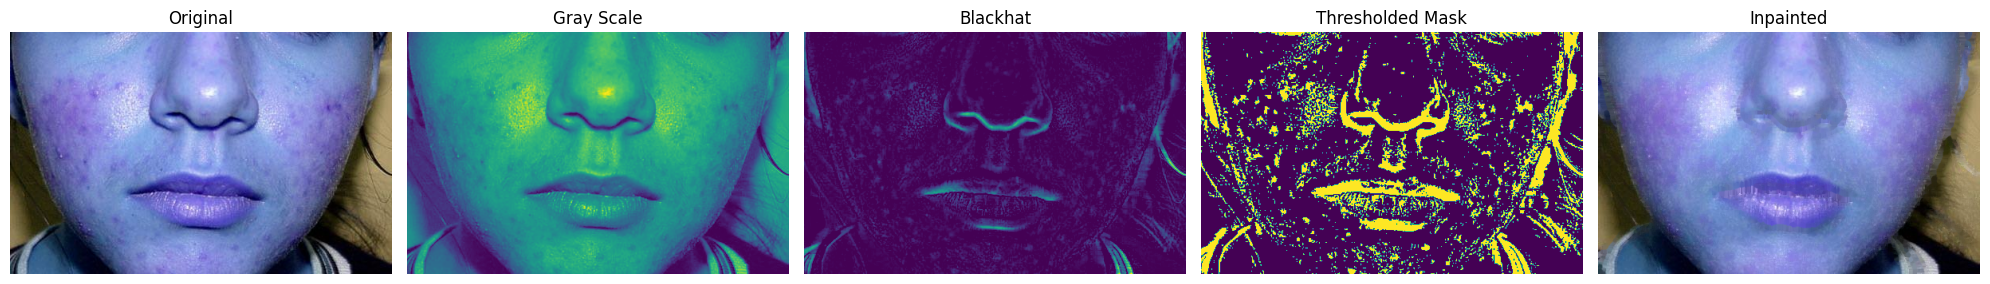

In [12]:
# *************************************
# Image preprocessing - hair removal
# *************************************

# code based on: https://github.com/sunnyshah2894/DigitalHairRemoval

# maybe instead of applying this transformations we should create a new train dataset?

def remove_hair(img, show_process=False):
    # Convert the original image to grayscale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1, (17, 17))

    # Perform the blackHat filtering on the grayscale image to find the 
    # hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # intensify the hair countours in preparation for the inpainting 
    # algorithm
    ret, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    dst = cv2.inpaint(img, thresh2, 1, cv2.INPAINT_TELEA)
    
    if show_process:
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 20))
        
        ax1.imshow(img)
        ax1.set_title('Original')
        ax1.axis('off')
        
        ax2.imshow(grayScale)
        ax2.set_title('Gray Scale')
        ax2.axis('off')
        
        ax3.imshow(blackhat)
        ax3.set_title('Blackhat')
        ax3.axis('off')
        
        ax4.imshow(thresh2)
        ax4.set_title('Thresholded Mask')
        ax4.axis('off')
        
        ax5.imshow(dst)
        ax5.set_title('Inpainted')
        ax5.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    
    else:
        return dst

# with hair
remove_hair(
    cv2.imread(os.path.join('data', 'train', 'acanthosis nigricans', '0a274b8475fa8cb5698a4473d670b1ef.jpg')),
    show_process=True
)

# without hair
remove_hair(
    cv2.imread(os.path.join('data', 'train', 'acne', '0e3b5b7c2a4852017252c865ef6b09b0.jpg')),
    show_process=True
)

In [49]:
# ******************************************
# Image preprocessing - background removal
# ******************************************

# much more complicated than it seems

# https://stackoverflow.com/questions/59817126/how-to-train-model-for-background-removal-from-images-in-machine-learning

# we would need to train a new model and since our images
# can either be close ups, full body, etc... it would be
# extremely hard to create a model that works for all cases

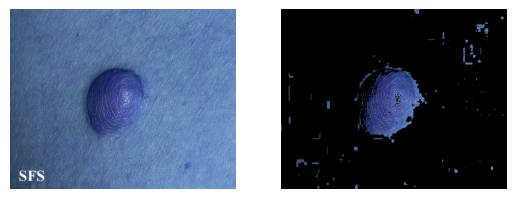

In [47]:
# ******************************************
# Image preprocessing - increasing contrast
# ******************************************

# https://stackoverflow.com/questions/50474302/how-do-i-adjust-brightness-contrast-and-vibrance-with-opencv-python

img_path = os.path.join('data', 'train', 'pilar cyst', '6c770bbf5b1394537ba9cb4c16050fe4.jpg')
img = cv2.imread(img_path)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # highlighting red
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
mask = cv2.inRange(hsv, lower_red, upper_red)
highlighted_red = cv2.bitwise_and(img, img, mask=mask)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax1.axis('off')
ax2.imshow(highlighted_red)
ax2.axis('off')
plt.show()

# for some images it works, for others it doesn't

In [13]:
# *********************************
# Metrics
# *********************************

METRICS = [
    F1Score(average='macro'),
    Precision(name='precision'),
    Recall(name='recall'),
    CategoricalAccuracy(name='categorical_accuracy'),
]

In [117]:
# *********************************
# Creating the baseline model
# *********************************

# the idea here is to use a pre-trained model for starters we'll use
# the VGG16 model as used in the paper that first showed the curated
# fitzpatrick17k dataset: same architecture and same data augmentation
# pipeline. This model will serve as a baseline to compare other models.

# useful links:
# - paper: https://arxiv.org/abs/2104.09957
# - code: https://github.com/mattgroh/fitzpatrick17k
# - transfer learning with keras: https://keras.io/guides/transfer_learning/

def baseline_model():
    
    batch_size = 256
    image_size = (224, 224)
    input_shape = image_size + (3,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)

    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights="imagenet",
        input_shape=input_shape  # must be (224, 224, 3) if include_top=True
    )

    # as per the paper they remove only the last layer (1000 classes)
    base_model = tf.keras.Model(inputs=base_model.input,
                                outputs=base_model.layers[-2].output,
                                name='base_model')

    # freezing the base model
    base_model.trainable = False

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4, seed=42),
        tf.keras.layers.Dense(114),
    ], name='head_model')
    
    # preprocessing pipeline
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline)

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),  # if True do not add final softmax layer
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)

    # augmenting the train data
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
        tf.keras.layers.RandomRotation(factor=0.15, seed=42),
        tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, seed=42),
        tf.keras.layers.RandomContrast(factor=0.15, seed=42)
    ], name='augmentation_pipeline')
    
    augmented_train_data = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))

    # we should preprocess the data before fitting according to the VGG16 model
    # vgg_16_preprocessed_train_data = augmented_train_data.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))
    # vgg_16_preprocessed_val_data = val_data.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y))

    history = model.fit(augmented_train_data,
                       epochs=50,
                       validation_data=val_data,
                       class_weight=CLASS_WEIGHTS,
                       callbacks=[LearningRateScheduler(lr_schedule)],
                       verbose=1)
    
    return model, history.history


# saving model & history
model_name = baseline_model.__name__
model, history = baseline_model()
model.save(os.path.join('model_dir', f'{model_name}.keras'))
save_model_history(history.history, f'{model_name}.pkl')

In [25]:
# *********************************
# V1 VGG16 model
# *********************************

def vgg16_v1():
    
    batch_size = 32
    image_size = (50, 50)
    input_shape = image_size + (3,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)
    
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False
    
    # ... but unfreezing the last set of conv. layers (3 layers)
    # for i, layer in enumerate(base_model.layers):
    #     if i > 14:
    #         layer.trainable = True
    
    print('\nTrainable base model layers')
    for i, layer in enumerate(base_model.layers):
        print(f'\t{i}, {layer.name}, {layer.trainable}')
    print()

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_initializer='uniform', bias_initializer='zeros'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(114, kernel_initializer='uniform', bias_initializer='zeros')
    ], name='head_model')
    
    # pre processing
    means, stds = get_mean_and_std(train_data, normalize=True)
    print(f'\nMeans: {means}, Stds: {stds}\n')
    
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),  # normalizing
        tf.keras.layers.Rescaling(scale=1.0 / stds, offset=-means / stds),  # standardizing
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline,
                          model_name='model_vgg16_v1')

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # augmentation
    augmentation_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal', seed=SEED),
        tf.keras.layers.RandomRotation(factor=0.15, seed=SEED),
        tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, seed=SEED),
        tf.keras.layers.RandomContrast(factor=0.15, seed=SEED)
    ], name='augmentation_pipeline')
    
    augmented_train = train_data.map(lambda x, y: (augmentation_pipeline(x, training=True), y))
    
    # model fitting  
    history = model.fit(augmented_train,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5)],
                        verbose=1)
    
    return model, history.history


model_name = vgg16_v1.__name__
model, history = vgg16_v1()
model.save(os.path.join('model_dir', 'models', f'{model_name}.keras'))
save_model_history(history, f'{model_name}.pkl')

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.

Trainable base model layers
	0, input_10, False
	1, block1_conv1, False
	2, block1_conv2, False
	3, block1_pool, False
	4, block2_conv1, False
	5, block2_conv2, False
	6, block2_pool, False
	7, block3_conv1, False
	8, block3_conv2, False
	9, block3_conv3, False
	10, block3_pool, False
	11, block4_conv1, False
	12, block4_conv2, False
	13, block4_conv3, False
	14, block4_pool, False
	15, block5_conv1, False
	16, block5_conv2, False
	17, block5_conv3, False
	18, block5_pool, False


Means: [0.6303048  0.48576036 0.42577952], Stds: [0.22198817 0.19741318 0.20049413]


Model: "model_vgg16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 50, 3)]       0         
                                                                 
 preproce

In [27]:
# *********************************
# V2 VGG16 model
# *********************************

def vgg16_v2():
    
    # NOTE
    # no data augmentation
    # removed batch normalization and added dropout
    
    batch_size = 32
    image_size = (50, 50)
    input_shape = image_size + (3,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)
    
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False
    
    # ... but unfreezing the last set of conv. layers (3 layers)
    # for i, layer in enumerate(base_model.layers):
    #     if i > 14:
    #         layer.trainable = True
    
    print('\nTrainable base model layers')
    for i, layer in enumerate(base_model.layers):
        print(f'\t{i}, {layer.name}, {layer.trainable}')
    print()

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_initializer='uniform', bias_initializer='zeros'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3, seed=SEED),
        tf.keras.layers.Dense(114, kernel_initializer='uniform', bias_initializer='zeros')
    ], name='head_model')
    
    # pre processing
    means, stds = get_mean_and_std(train_data, normalize=True)
    print(f'\nMeans: {means}, Stds: {stds}\n')
    
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),  # normalizing
        tf.keras.layers.Rescaling(scale=1.0 / stds, offset=-means / stds),  # standardizing
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline,
                          model_name='model_vgg16_v1')

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # model fitting  
    history = model.fit(train_data,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5)],
                        verbose=1)
    
    return model, history.history


model_name = vgg16_v2.__name__
model, history = vgg16_v2()
model.save(os.path.join('model_dir', 'models', f'{model_name}.keras'))
save_model_history(history, f'{model_name}.pkl')

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.

Trainable base model layers
	0, input_11, False
	1, block1_conv1, False
	2, block1_conv2, False
	3, block1_pool, False
	4, block2_conv1, False
	5, block2_conv2, False
	6, block2_pool, False
	7, block3_conv1, False
	8, block3_conv2, False
	9, block3_conv3, False
	10, block3_pool, False
	11, block4_conv1, False
	12, block4_conv2, False
	13, block4_conv3, False
	14, block4_pool, False
	15, block5_conv1, False
	16, block5_conv2, False
	17, block5_conv3, False
	18, block5_pool, False


Means: [0.6303048  0.48576036 0.42577952], Stds: [0.22198817 0.19741318 0.20049413]


Model: "model_vgg16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 50, 3)]       0         
                                                                 
 preproce

In [28]:
# *********************************
# V3 VGG16 model
# *********************************

def vgg16_v3():
    
    # NOTE
    # with data augmentation
    # dropout
    # unfrozen 4 layers
    
    batch_size = 32
    image_size = (50, 50)
    input_shape = image_size + (3,)
    
    train_data, val_data, test_data = import_data(batch_size=batch_size, image_size=image_size)
    
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    # freezing the base model...
    base_model.trainable = False
    
    # ... but unfreezing the last set of conv. layers (3 layers)
    for i, layer in enumerate(base_model.layers):
        if i > 14:
            layer.trainable = True
    
    print('\nTrainable base model layers')
    for i, layer in enumerate(base_model.layers):
        print(f'\t{i}, {layer.name}, {layer.trainable}')
    print()

    # head layers
    head_model = tf.keras.models.Sequential([    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_initializer='uniform', bias_initializer='zeros'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3, seed=SEED),
        tf.keras.layers.Dense(114, kernel_initializer='uniform', bias_initializer='zeros')
    ], name='head_model')
    
    # pre processing
    means, stds = get_mean_and_std(train_data, normalize=True)
    print(f'\nMeans: {means}, Stds: {stds}\n')
    
    preprocessing_pipeline = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255),  # normalizing
        tf.keras.layers.Rescaling(scale=1.0 / stds, offset=-means / stds),  # standardizing
    ], name='preprocessing_pipeline')

    # building the model
    model = model_builder(head_model,
                          input_shape,
                          base_model=base_model,
                          preprocessing_pipeline=preprocessing_pipeline,
                          model_name='model_vgg16_v1')

    compile_kwargs = {
        'optimizer': tf.keras.optimizers.Adam(learning_rate=0.0001),
        'loss': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        'metrics': METRICS
    }

    model.compile(**compile_kwargs)
    
    print()
    model.summary()
    print()
    
    # model fitting  
    history = model.fit(train_data,
                        epochs=50,
                        validation_data=val_data,
                        class_weight=CLASS_WEIGHTS,
                        callbacks=[EarlyStopping(patience=5)],
                        verbose=1)
    
    return model, history.history


model_name = vgg16_v3.__name__
model, history = vgg16_v3()
model.save(os.path.join('model_dir', 'models', f'{model_name}.keras'))
save_model_history(history, f'{model_name}.pkl')

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.

Trainable base model layers
	0, input_12, False
	1, block1_conv1, False
	2, block1_conv2, False
	3, block1_pool, False
	4, block2_conv1, False
	5, block2_conv2, False
	6, block2_pool, False
	7, block3_conv1, False
	8, block3_conv2, False
	9, block3_conv3, False
	10, block3_pool, False
	11, block4_conv1, False
	12, block4_conv2, False
	13, block4_conv3, False
	14, block4_pool, False
	15, block5_conv1, True
	16, block5_conv2, True
	17, block5_conv3, True
	18, block5_pool, True


Means: [0.6303048  0.48576036 0.42577952], Stds: [0.22198817 0.19741318 0.20049413]


Model: "model_vgg16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 50, 3)]       0         
                                                                 
 preprocessin

KeyboardInterrupt: 

In [ ]:
# *********************************
# Tensorboard
# *********************************

# run:
!tensorboard --logdir=log_dir --host localhost --port 6006
# go to: http://localhost:6006/
# 'interrupt' this cell once you are done

In [23]:
# *****************************
# Comparing models
# *****************************

def compare_models(histories: Union[dict, list[dict]],
                   *,
                   names: Union[str, list[str]] = 'Model',
                   metrics: Union[list[tuple], tuple] = ('loss', 'val_loss')):
    """
    Plots the training and validation history of one or more models.

    Args:
        histories: A dictionary or a list of dictionaries containing the training and validation
        history of the models. Each dictionary should have the metrics as keys and the corresponding values as lists.
        names: The names of the models. It can be a single string or a list of strings.
        Defaults to 'Model'.
        metrics: The metrics to plot. It can be a single tuple or a list of tuples.
        Each tuple should contain two strings representing the training metric and the validation metric.
        Defaults to ('loss', 'val_loss').

    Raises:
        ValueError: If no histories are provided or if the metrics argument is not a list or a tuple.
        ValueError: If the histories do not share the same metrics.

    Returns:
        None
    """
    if not histories:
        raise ValueError('No histories to plot.')

    if isinstance(histories, dict):
        histories = [histories]

    if isinstance(names, str):
        names = [names] * len(histories)

    if isinstance(metrics, tuple):
        metrics = [metrics]
    elif not isinstance(metrics, list):
        raise ValueError('metrics must be a list or a tuple.')

    # all histories must share the same metrics
    u_metrics = set([metric for pair in metrics for metric in pair])
    if not all(set(hist.keys()).issuperset(u_metrics) for hist in histories):
        raise ValueError('Histories must share the same metrics.')

    # for each metric pair (train, val) we want to plot, on the same plot
    # the history of each model for that pair of metrics
    for i, (train_metric, val_metric) in enumerate(metrics):
        
        # ax1 for train, ax2 for val
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
        fig.suptitle(f'{train_metric} and {val_metric} History')
        
        for j, history in enumerate(histories):
            ax1.plot(history[train_metric], label=f'{names[j]}')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel(train_metric)
            ax1.legend(loc="upper right")
            ax1.grid(True)

        for k, history in enumerate(histories):
            ax2.plot(history[val_metric], label=f'{names[k]}')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel(val_metric)
            ax2.legend(loc="upper right")
            ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

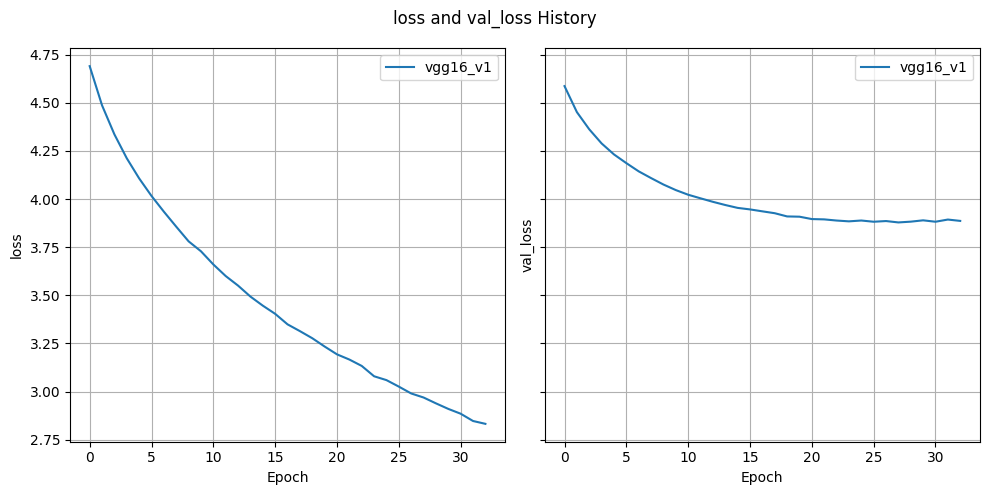

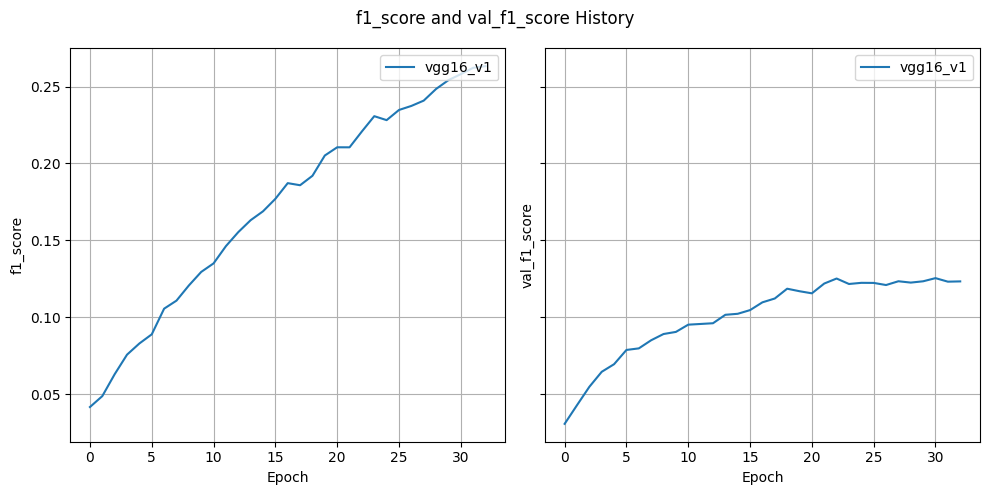

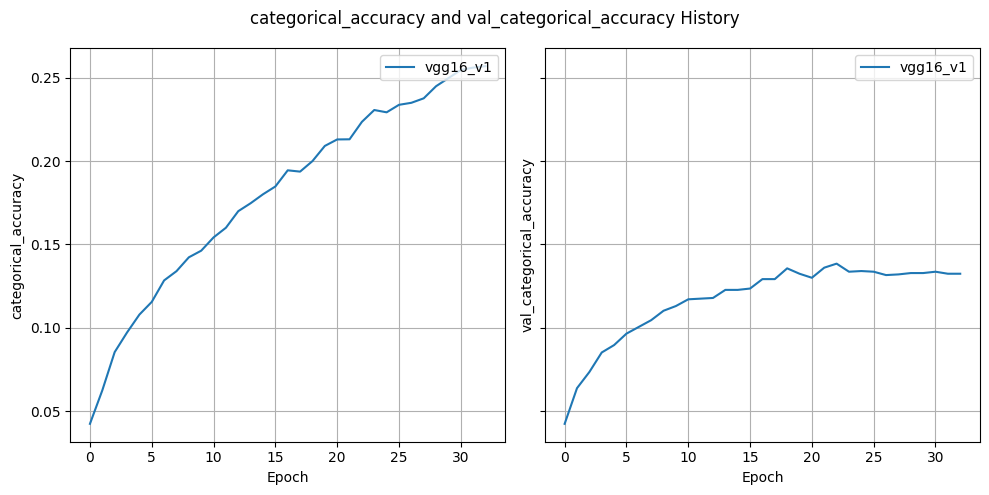

In [ ]:
# BEST MODEL SO FAR:
# Preprocessing: Rescaling(1./255)
# Base model: VGG16 (include_top=False)
# Head model: Dense(256), Activation('relu'), Dropout(0.4), Dense(114)
# Data augmentation: RandomFlip(mode='horizontal'), RandomRotation(factor=0.15), RandomZoom(height_factor=0.15, width_factor=0.15), RandomContrast(factor=0.15)
# Optimizer: Adam(learning_rate=0.01)
# Loss: CategoricalCrossentropy(from_logits=True)
# Batch size: 32
# Image size: (128, 128) RGB

# import histories

history_files = ['vgg16_v1.pkl', 'vgg16_v2.pkl', 'vgg16_v3.pkl']
histories, names = [], []
for file in history_files:
    histories.append(load_model_history(file))
    names.append(file[:-4])

compare_models(histories,
               names=names,
               metrics=[('loss', 'val_loss'),
                        ('f1_score', 'val_f1_score'),
                        ('categorical_accuracy', 'val_categorical_accuracy')])

# val loss increasing but f1 score and accuracy increasing as well?! https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy

In [ ]:
# **********************************
# Sample of prediction results
# **********************************

# the idea here is to show a sample of the
# images that our model got wrong (or right)
# to quickly and roughly assess the model's
# prediction quality

X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])
y_val_pred = np.argmax(baseline_model.predict(vgg_16_preprocessed_val_data), axis=1)  # NOTE use the preprocessed val data

ModelVisualEvaluation.plot_prediction_sample(X_val, y_val_true,
                                             y_val_pred, show_class=1,
                                             only_show_wrong=True)

# TODO: maybe use this in conjunction with grad cam??

In [ ]:
# **********************************
# Benign vs. malign classification
# **********************************

# our main objective is to predict a class on a set of 114
# possible classes. Nonetheless, we believe that we also can
# and should assess our model's performance, as first-line metric,
# based on whether is it predicting correctly if the skin disease
# presented is benign or malign.

def convert_to_binary_classification_mode(y_true: np.ndarray, y_pred: np.ndarray,
                                          malign_disease_map: dict = MALIGN_DISEASES) -> tuple[np.ndarray]:
    """
    Converts the multi-class classification into a binary classification
    mode. The idea is to map all the classes that are malign into a single
    class and all the others into another class.
    
    Args:
        y_true: true labels
        y_pred: predicted labels
        malign_disease_map: dict mapping malign diseases to their respective class
        
    Returns:
        tuple: y_true_bin, y_pred_bin
    """
    mapper = lambda arr: [malign_disease_map[i] for i in arr]
    y_true_bin = mapper(y_true)
    y_pred_bin = mapper(y_pred)
    return (y_true_bin, y_pred_bin)


# from the previous cell we already have y val, pred and true
y_val_bin_true, y_val_bin_pred = convert_to_binary_classification_mode(y_val_true, y_val_pred)

# quality assessment
print('Classification Report:')
print(classification_report(y_val_bin_true, y_val_bin_pred))

In [ ]:
# **********************************
# Evaluation on skin types
# **********************************

# the idea here is to check whether our
# model is biased towards a specific skin
# type.

# steps:
# 1. get the skin type of each image
# 2. get the true and predicted labels
# 3. get the confusion matrix for each skin type

# NOTE use non-shuffled data

CSV_DATA = pd.read_csv('data/fitzpatrick17k.csv')

def map_img_path_to_skin_type(img_path: str) -> str:
    # parse img path to get hash
    img_hash = os.path.split(img_path)[-1][:-4]
    # get skin type
    skin_type = CSV_DATA.loc[CSV_DATA['md5hash'] == img_hash, 'fitzpatrick_scale'].values[0]
    return skin_type

instances_per_skin_type = {}
correct_predictions_per_skin_type = {}
for true_label, pred_label, img_path in zip(y_val_true, y_val_pred, val_data.file_paths):
    skin_type = map_img_path_to_skin_type(img_path)
    if skin_type not in instances_per_skin_type:
        instances_per_skin_type[skin_type] = 0
        correct_predictions_per_skin_type[skin_type] = 0
    instances_per_skin_type[skin_type] += 1
    if true_label == pred_label:
        correct_predictions_per_skin_type[skin_type] += 1

# confusion matrix per skin type
# for skin_type in instances_per_skin_type:
#     print(f'Skin Type: {skin_type}')
#     print(f'Instances: {instances_per_skin_type[skin_type]}')
#     print(f'Correct Predictions: {correct_predictions_per_skin_type[skin_type]}')
#     print(f'Accuracy: {correct_predictions_per_skin_type[skin_type] / instances_per_skin_type[skin_type]}')
#     print()

# plotting accuracy by skin type
skin_types = list(instances_per_skin_type.keys())
accuracies = [correct_predictions_per_skin_type[skin_type] / instances_per_skin_type[skin_type] for skin_type in skin_types]
avg_accuracy = np.mean(accuracies)
plt.bar(x=skin_types, height=accuracies)
plt.axhline(y=avg_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {avg_accuracy:.2f}')
plt.legend()
plt.show()

In [ ]:
# **********************************
# Top-5 Accuracy
# **********************************

# this is a common metric to assess the performance
# of models in multi-class classification problems.
# It is the proportion of times the true class is in
# the top-5 predicted classes.

def top_5_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the top-5 accuracy.
    
    Args:
        y_true: true labels
        y_pred: predicted labels, one hot encoded
        (proba. for each class)
        
    Returns:
        float: top-5 accuracy
    """
    top_5 = np.argsort(y_pred, axis=1)[:, -5:]
    top_5 = np.array([i in j for i, j in zip(y_true, top_5)])
    return np.mean(top_5)

# one hot encoded
y_val_pred_ohe = baseline_model.predict(vgg_16_preprocessed_val_data)
top_5_accuracy(y_val_true, y_val_pred_ohe)

In [ ]:
# possible SoTA model
# https://keras.io/api/applications/convnext/
# https://arxiv.org/pdf/2201.03545.pdf